Análise do dia 01/04 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Preparação dos dados

In [2]:
# import dos dados

df = pd.read_csv('0104_preprocessado.csv')

In [3]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [4]:
# aplica função em todos os tokens

df['token3'] = df['token3'].apply(lambda x: strip_characters(x))
df['token3'] = df['token3'].apply(lambda x: str(x).split(' '))

In [5]:
texto = list(df.token3)

# Modelagem

In [6]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [7]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [8]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [10:32<00:00, 45.20s/it]


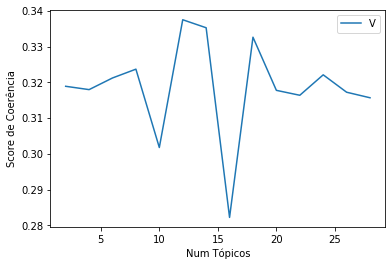

In [10]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [11]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3189
A quantidade de tópicos = 4  tem um valor de coerência de  0.318
A quantidade de tópicos = 6  tem um valor de coerência de  0.3212
A quantidade de tópicos = 8  tem um valor de coerência de  0.3237
A quantidade de tópicos = 10  tem um valor de coerência de  0.3018
A quantidade de tópicos = 12  tem um valor de coerência de  0.3375
A quantidade de tópicos = 14  tem um valor de coerência de  0.3353
A quantidade de tópicos = 16  tem um valor de coerência de  0.2822
A quantidade de tópicos = 18  tem um valor de coerência de  0.3326
A quantidade de tópicos = 20  tem um valor de coerência de  0.3178
A quantidade de tópicos = 22  tem um valor de coerência de  0.3164
A quantidade de tópicos = 24  tem um valor de coerência de  0.3221
A quantidade de tópicos = 26  tem um valor de coerência de  0.3172
A quantidade de tópicos = 28  tem um valor de coerência de  0.3157


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [16]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=3, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

In [17]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.1403837033588


In [18]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.3593261037029136


In [19]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.171151 -0.343922       1        1  36.949295
1     -0.217375  0.317684       2        1  31.825676
2      0.388526  0.026238       3        1  31.225019, topic_info=           Term          Freq         Total Category  logprob  loglift
19    bolsonaro  21614.000000  21614.000000  Default  30.0000  30.0000
69   presidente  17695.000000  17695.000000  Default  29.0000  29.0000
59               11840.000000  11840.000000  Default  28.0000  28.0000
5      pandemia  10727.000000  10727.000000  Default  27.0000  27.0000
52         casa   7793.000000   7793.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
303       volta   1125.986328   1126.623413   Topic3  -5.3049   1.1634
73         algo   1058.731323   1059.364136   Topic3  -5.3665   1.1634
199        dois   1033.294800   1033.917725   Topic3  -5.3908   1.1633
136       igual   1038.466064   1039.093506   Topic3  -5.3858   1.1633
225      passar   2884.422119   2889.093018   Topic3  -4.3642   1.1623

[123 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        2  0.999943         
13        2  0.999849   acabar
299       3  0.999846    agora
73        3  0.999656     algo
579       2  0.999439   alguem
...     ...       ...      ...
116       2  0.999734     vida
238       3  0.999482    video
303       3  0.999447    volta
117       2  0.999575   voltar
93        2  0.999397  vontade

[95 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [20]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=4, step=2)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.89s/it]


In [22]:
# Escolhe o modelo

optimal_model = model_list[0]
optimal_model.print_topics(num_topics = 3, num_words = 20)

[(0,
  '0.062*"" + 0.021*"bolsonaro" + 0.014*"contra" + 0.013*"depois" + 0.013*"pandemia" + 0.013*"nunca" + 0.011*"nem" + 0.010*"sim" + 0.009*"vida" + 0.009*"novo" + 0.008*"logo" + 0.008*"presidente" + 0.007*"saude" + 0.007*"isolamento" + 0.005*"comer" + 0.005*"deus" + 0.005*"social" + 0.005*"mil" + 0.005*"tomar" + 0.005*"agora"'),
 (1,
  '0.054*"presidente" + 0.029*"bolsonaro" + 0.020*"brasil" + 0.020*"pandemia" + 0.014*"muito" + 0.013*"agora" + 0.013*"gente" + 0.008*"passar" + 0.007*"quando" + 0.007*"abril" + 0.006*"cabelo" + 0.006*"meio" + 0.006*"menos" + 0.006*"povo" + 0.006*"governo" + 0.006*"deus" + 0.006*"porque" + 0.006*"tambem" + 0.005*"tempo" + 0.005*"ano"'),
 (2,
  '0.032*"bolsonaro" + 0.032*"casa" + 0.023*"acabar" + 0.019*"quando" + 0.013*"sair" + 0.012*"mundo" + 0.011*"pandemia" + 0.009*"mae" + 0.009*"gente" + 0.008*"ir" + 0.008*"nada" + 0.008*"nem" + 0.008*"video" + 0.007*"coisa" + 0.007*"vez" + 0.006*"pai" + 0.006*"agora" + 0.006*"governo" + 0.006*"melhor" + 0.006*"povo"

In [23]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texto):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [24]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texto)

In [25]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9700,", bolsonaro, contra, depois, pandemia, nunca, ...","[views, volta, daniel, marcela, fancam, thelma..."
1,1.0,0.9610,"presidente, bolsonaro, brasil, pandemia, muito...","[preocupado, planalto, pergunta, contexto, ras..."
2,2.0,0.9543,"bolsonaro, casa, acabar, quando, sair, mundo, ...","[medo, sair, poder, saber, casa, feito, femini..."


In [27]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,0.0,", bolsonaro, contra, depois, pandemia, nunca, ...",51427.0,0.2949
1.0,1.0,"presidente, bolsonaro, brasil, pandemia, muito...",64548.0,0.3701
2.0,2.0,"bolsonaro, casa, acabar, quando, sair, mundo, ...",58437.0,0.3351
3.0,1.0,"presidente, bolsonaro, brasil, pandemia, muito...",NaN,NaN
4.0,2.0,"bolsonaro, casa, acabar, quando, sair, mundo, ...",NaN,NaN
...,...,...,...,...
174407.0,0.0,", bolsonaro, contra, depois, pandemia, nunca, ...",NaN,NaN
174408.0,1.0,"presidente, bolsonaro, brasil, pandemia, muito...",NaN,NaN
174409.0,1.0,"presidente, bolsonaro, brasil, pandemia, muito...",NaN,NaN
174410.0,0.0,", bolsonaro, contra, depois, pandemia, nunca, ...",NaN,NaN


In [28]:
# Criando stopwords em português utilizando a biblioteca nltk
import pt_core_news_sm
nlp = pt_core_news_sm.load()
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior',
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'tem', 'as', 'mas','ao'
                    'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkk','kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'obg',
                    'corona','virus','coronavirus','covid','covid19','19'
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda',
                    'vir', 'bem','ao','sem','ou','vai', 'dizer', 'entao', 'dizer', 'entao',
                    'tao', 'tu', 'mim', 'mano', 'oq', 'pos', 'dm', 'dps',
                    'coronavirusoutbreak', 'coronavirusPandemic', 'dar', 'vairus',
                    'ainda', 'assim']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

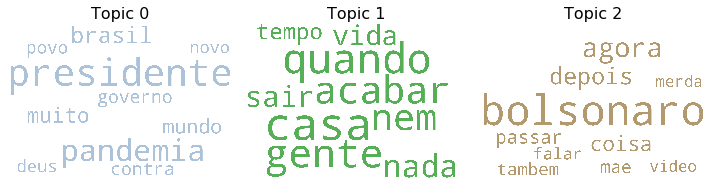

In [31]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [32]:
sent_topics_sorteddf_mallet.to_excel('keywords_0401.xlsx')